# Create the df and the data to work with transformer network

In [1]:
import os
import pickle
import pandas as pd
import numpy as np

import cv2
from scipy import interpolate
from scipy.ndimage import rotate
from skimage.morphology import skeletonize
from skimage.morphology import binary_closing
from skimage.filters import threshold_otsu
from skimage.filters import frangi

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch

In [2]:
PATH_TO_ARTERY_REGION_DF = "../../CVD_detection_code/Data_CVD/patient_2_view_info"

# Create the df

In [3]:
region_level_df = pd.read_pickle(PATH_TO_ARTERY_REGION_DF)
nb_mi_patient_start = np.sum(region_level_df.reset_index().groupby("patient_name").agg({"target_box":pd.Series.max}).values)
print("{} init number of patients, {} with MI".format(len(region_level_df["patient_name"].unique()), nb_mi_patient_start))
region_level_df.head(3)

469 init number of patients, 47 with MI


,path_view1,path_view2,coord_view1,coord_view2,patient_name,segment_box,color_box,target_box
0,Z:/cardio/SPUM/Labelling_EPFL_CHUV\Farhang MI ...,Z:/cardio/SPUM/Labelling_EPFL_CHUV\Farhang MI ...,"[[933, 368], [812, 457], [1066, 802], [1188, 7...","[[655, 396], [494, 425], [598, 1009], [759, 980]]",patient1,LAD,brown,0
1,Z:/cardio/SPUM/Labelling_EPFL_CHUV\Farhang MI ...,Z:/cardio/SPUM/Labelling_EPFL_CHUV\Farhang MI ...,"[[691, 133], [629, 197], [863, 422], [925, 357]]","[[564, 120], [463, 141], [523, 421], [624, 399]]",patient1,LAD,green,0
2,Z:/cardio/SPUM/Labelling_EPFL_CHUV\Farhang MI ...,Z:/cardio/SPUM/Labelling_EPFL_CHUV\Farhang MI ...,"[[420, 122], [276, 164], [304, 258], [448, 216]]","[[375, 4], [369, 101], [474, 108], [480, 11]]",patient1,LAD,magenta,0


In [4]:
# Adapt the path
region_level_df["path_view1"] = region_level_df["path_view1"].str.replace('/data/cardio/SPUM', '../..')
region_level_df["path_view2"] = region_level_df["path_view2"].str.replace('/data/cardio/SPUM', '../..')
region_level_df["path_view1"] = region_level_df["path_view1"].str.replace('Z:/cardio/SPUM', '../..')
region_level_df["path_view2"] = region_level_df["path_view2"].str.replace('Z:/cardio/SPUM', '../..')
region_level_df["path_view1"] = region_level_df["path_view1"].str.replace('\\', '/', regex=False)
region_level_df["path_view2"] = region_level_df["path_view2"].str.replace('\\', '/', regex=False)


# We want the image without the boxes
region_level_df["path_view1"] = region_level_df["path_view1"].str[:-4]
region_level_df["path_view2"] = region_level_df["path_view2"].str[:-4]
region_level_df["path_view1"] = region_level_df["path_view1"] + " copie.tif"
region_level_df["path_view2"] = region_level_df["path_view2"] + " copie.tif"

# Replace typo
region_level_df["segment_box"] = region_level_df["segment_box"].str.replace('LCx', 'LCX', regex=False)

We group per patient, for now we ingore magenta dark boxes (not studied here) and blue boxes (too few patients have it)

In [5]:
# Group to have for each patient
region_level_df_boxes = region_level_df.copy()
region_level_df_boxes = region_level_df_boxes[region_level_df_boxes["color_box"] != "magenta_dark"] # remove CABG
region_level_df_boxes = region_level_df_boxes[region_level_df_boxes["color_box"] != "blue"]
region_level_df_boxes = region_level_df_boxes.groupby(["patient_name", "segment_box", "color_box"]).agg({
    "path_view1": list, 
    "path_view2": list, 
    "coord_view1": list, 
    "coord_view2": list, 
    "target_box": list
    })
region_level_df_boxes_tmp = region_level_df_boxes.copy()
region_level_df_boxes_tmp["target_box"] = list(map(max, region_level_df_boxes_tmp["target_box"]))
nb_mi_patient = np.sum(region_level_df_boxes_tmp.reset_index().groupby("patient_name").agg({"target_box":pd.Series.max}).values)
print("{} patients lost. {} MI lost".format(len(region_level_df["patient_name"].unique())-len(region_level_df_boxes.index.get_level_values("patient_name").unique()), nb_mi_patient_start-nb_mi_patient))

0 patients lost. 2 MI lost


In [6]:
df_test = region_level_df_boxes.copy()
df_test = df_test[df_test["target_box"].str.len() > 1]
print("{} patients have various entries for same box".format(len(df_test.index.get_level_values("patient_name").unique())))

84 patients have various entries for same box


In [7]:
# Check that there is no situation with the box has a representation that contains MI which is not the first
region_level_df_boxes_tmp = region_level_df_boxes.copy()
region_level_df_boxes_tmp["target_box"] = list(map(np.argmax, region_level_df_boxes_tmp["target_box"]))
region_level_df_boxes_tmp[region_level_df_boxes_tmp["target_box"] != 0]

,,,path_view1,path_view2,coord_view1,coord_view2,target_box
patient_name,segment_box,color_box,,,,,


In [8]:
# When various entries take the first one
region_level_df_boxes = region_level_df_boxes.applymap(lambda x: x[0])
nb_mi_patient = np.sum(region_level_df_boxes.reset_index().groupby("patient_name").agg({"target_box":pd.Series.max}).values)
print("{} patients lost. {} MI lost".format(len(region_level_df["patient_name"].unique())-len(region_level_df_boxes.index.get_level_values("patient_name").unique()), nb_mi_patient_start-nb_mi_patient))

0 patients lost. 2 MI lost


In [9]:
# Find the patient arteries with all the boxes
nb_data_per_patient = region_level_df_boxes.reset_index(level=[2]).index.value_counts()
idx_array = np.array([*nb_data_per_patient.index.to_list()])
df_nb_boxes = pd.DataFrame({"patient_name":idx_array[:,0], "segment_box":idx_array[:,1], "nb_boxes":nb_data_per_patient.values})
df_nb_boxes = df_nb_boxes[df_nb_boxes["nb_boxes"]==4].set_index(["patient_name", "segment_box"])

In [10]:
region_level_df_boxes_all_boxes = region_level_df_boxes.reset_index(level=2).loc[df_nb_boxes.index].reset_index().groupby(
    ["patient_name", "segment_box", "color_box"]).agg(pd.Series.mode)
region_level_df_boxes_all_boxes

path_view1  \
patient_name segment_box color_box                                                      
patient1     LAD         brown      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
                         green      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
                         magenta    ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
                         yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
             RCA         brown      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
...                                                                               ...   
patient99    LAD         yellow     ../../Labelling_EPFL_CHUV/Farhang NCL/078-760-...   
             LCX         brown      ../../Labelling_EPFL_CHUV/Farhang NCL/078-760-...   
                         green      ../../Labelling_EPFL_CHUV/Farhang NCL/078-760-...   
                         magenta    ../../Labelling_EPFL_CHUV/Farhang NCL/078-760-...   
                         yellow     ../../Labelling_EPFL_CHUV/Farhang NCL/078-760-...   

                                                                           path_view2  \
patient_name segment_box color_box                                                      
patient1     LAD         brown      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
                         green      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
                         magenta    ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
                         yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
             RCA         brown      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
...                                                                               ...   
patient99    LAD         yellow     ../../Labelling_EPFL_CHUV/Farhang NCL/078-760-...   
             LCX         brown      ../../Labelling_EPFL_CHUV/Farhang NCL/078-760-...   
                         green      ../../Labelling_EPFL_CHUV/Farhang NCL/078-760-...   
                         magenta    ../../Labelling_EPFL_CHUV/Farhang NCL/078-760-...   
                         yellow     ../../Labelling_EPFL_CHUV/Farhang NCL/078-760-...   

                                                                          coord_view1  \
patient_name segment_box color_box                                                      
patient1     LAD         brown      [[933, 368], [812, 457], [1066, 802], [1188, 7...   
                         green       [[691, 133], [629, 197], [863, 422], [925, 357]]   
                         magenta     [[420, 122], [276, 164], [304, 258], [448, 216]]   
                         yellow       [[483, 74], [456, 161], [621, 213], [649, 127]]   
             RCA         brown      [[522, 358], [290, 745], [902, 1111], [1133, 7...   
...                                                                               ...   
patient99    LAD         yellow      [[565, 536], [275, 510], [263, 643], [554, 668]]   
             LCX         brown      [[1297, 945], [449, 113], [357, 207], [1205, 1...   
                         green       [[1332, 1520], [1332, 643], [5, 643], [5, 1520]]   
                         magenta       [[215, 125], [97, 125], [97, 222], [215, 222]]   
                         yellow      [[620, 584], [343, 106], [174, 204], [451, 682]]   

                                                                          coord_view2  \
patient_name segment_box color_box                                                      
patient1     LAD         brown      [[655, 396], [494, 425], [598, 1009], [759, 980]]   
                         green       [[564, 120], [463, 141], [523, 421], [624, 399]]   
                         magenta        [[375, 4], [369, 101], [474, 108], [480, 11]]   
                         yellow        [[523, 69], [455, 93], [474, 145], [542, 121]]   
             RCA         brown      [[1086, 595], [328, 839], [416,

In [11]:
nb_mi_patient = np.sum(region_level_df_boxes_all_boxes.reset_index().groupby("patient_name").agg({"target_box":pd.Series.max}).values)
print("{} patients lost. {} MI lost".format(len(region_level_df["patient_name"].unique())-len(region_level_df_boxes_all_boxes.index.get_level_values("patient_name").unique()), nb_mi_patient_start-nb_mi_patient))
print("{} final number of patients, {} with MI".format(len(region_level_df_boxes_all_boxes.index.get_level_values("patient_name").unique()), nb_mi_patient))

2 patients lost. 7 MI lost
467 final number of patients, 40 with MI


In [12]:
# Show the data of a random patient
patient_names = region_level_df_boxes_all_boxes.index.get_level_values("patient_name")
patient = patient_names[int(len(patient_names)*np.random.random())]
print(patient)
region_level_df_boxes_all_boxes.loc[patient]

patient17


path_view1  \
segment_box color_box                                                      
LAD         brown      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
            green      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
            magenta    ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
            yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
LCX         brown      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
            green      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
            magenta    ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
            yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
RCA         brown      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
            green      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
            magenta    ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
            yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   

                                                              path_view2  \
segment_box color_box                                                      
LAD         brown      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
            green      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
            magenta    ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
            yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
LCX         brown      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
            green      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
            magenta    ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
            yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
RCA         brown      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
            green      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
            magenta    ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
            yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   

                                                             coord_view1  \
segment_box color_box                                                      
LAD         brown      [[597, 331], [370, 286], [141, 1451], [368, 14...   
            green       [[635, 169], [547, 169], [547, 313], [635, 313]]   
            magenta       [[469, 122], [431, 15], [342, 46], [380, 154]]   
            yellow         [[630, 165], [624, -1], [479, 3], [484, 170]]   
LCX         brown      [[1114, 515], [1106, 339], [124, 382], [132, 5...   
            green      [[861, 1509], [861, 681], [180, 681], [180, 15...   
            magenta           [[72, 477], [1, 477], [1, 598], [72, 598]]   
            yellow       [[275, 665], [140, 497], [56, 564], [191, 732]]   
RCA         brown      [[1468, 1518], [1468, 1308], [385, 1308], [385...   
            green      [[380, 1367], [39, 1357], [35, 1476], [376, 14...   
            magenta     [[408, 644], [337, 561], [187, 688], [258, 772]]   
            yellow       [[239, 700], [20, 693], [1, 1353], [221, 1359]]   

                                                             coord_view2  \
segment_box color_box                                                      
LAD         brown      [[1447, 763], [984, 76], [836, 176], [1299, 862]]   
            green       [[851, 241], [826, 142], [414, 247], [439, 347]]   
            magenta           [[78, 519], [78, 399], [1, 399], [1, 519]]   
            yellow       [[426, 331], [398, 235], [75, 329], [103, 425]]   
LCX         brown      [[1058, 484], [950, 421], [791, 694], [899, 757]]   
            green      [[1485, 1420], [1458, 779], [884, 803], [911, ...   
            magenta     [[802, 750], [724, 698], [677, 768], [755, 820]]   
            yellow      [[933, 832], [827, 711], [759, 770], [865, 891]]   
RCA         brown      [[1516, 1513], [1516, 1047], [801, 1047], [801...   
            green      [[792, 1

In [13]:
tmp_df = region_level_df_boxes_all_boxes.reset_index(level=[1,2]).index.value_counts()//4
print("{} patients have the three arteries complete".format(len(tmp_df[tmp_df==3])))
print("{} patients have the two arteries complete".format(len(tmp_df[tmp_df==2])))
print("{} patients have the one arteries complete".format(len(tmp_df[tmp_df==1])))

344 patients have the three arteries complete
106 patients have the two arteries complete
17 patients have the one arteries complete


A lot of patients have missing boxes (especially the ones with MI)

In [14]:
# Save it
pkl_file = open('transformer_df.pkl', 'wb')
pickle.dump(region_level_df_boxes_all_boxes, pkl_file)

# Box and centerline extraction

### Reload the df 

In [2]:
pkl_file = open('transformer_df.pkl', 'rb')
region_level_df_boxes_complete = pickle.load(pkl_file)
region_level_df_boxes_complete

path_view1  \
patient_name segment_box color_box                                                      
patient1     LAD         brown      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
                         green      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
                         magenta    ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
                         yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
             RCA         brown      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
...                                                                               ...   
patient99    LAD         yellow     ../../Labelling_EPFL_CHUV/Farhang NCL/078-760-...   
             LCX         brown      ../../Labelling_EPFL_CHUV/Farhang NCL/078-760-...   
                         green      ../../Labelling_EPFL_CHUV/Farhang NCL/078-760-...   
                         magenta    ../../Labelling_EPFL_CHUV/Farhang NCL/078-760-...   
                         yellow     ../../Labelling_EPFL_CHUV/Farhang NCL/078-760-...   

                                                                           path_view2  \
patient_name segment_box color_box                                                      
patient1     LAD         brown      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
                         green      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
                         magenta    ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
                         yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
             RCA         brown      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
...                                                                               ...   
patient99    LAD         yellow     ../../Labelling_EPFL_CHUV/Farhang NCL/078-760-...   
             LCX         brown      ../../Labelling_EPFL_CHUV/Farhang NCL/078-760-...   
                         green      ../../Labelling_EPFL_CHUV/Farhang NCL/078-760-...   
                         magenta    ../../Labelling_EPFL_CHUV/Farhang NCL/078-760-...   
                         yellow     ../../Labelling_EPFL_CHUV/Farhang NCL/078-760-...   

                                                                          coord_view1  \
patient_name segment_box color_box                                                      
patient1     LAD         brown      [[933, 368], [812, 457], [1066, 802], [1188, 7...   
                         green       [[691, 133], [629, 197], [863, 422], [925, 357]]   
                         magenta     [[420, 122], [276, 164], [304, 258], [448, 216]]   
                         yellow       [[483, 74], [456, 161], [621, 213], [649, 127]]   
             RCA         brown      [[522, 358], [290, 745], [902, 1111], [1133, 7...   
...                                                                               ...   
patient99    LAD         yellow      [[565, 536], [275, 510], [263, 643], [554, 668]]   
             LCX         brown      [[1297, 945], [449, 113], [357, 207], [1205, 1...   
                         green       [[1332, 1520], [1332, 643], [5, 643], [5, 1520]]   
                         magenta       [[215, 125], [97, 125], [97, 222], [215, 222]]   
                         yellow      [[620, 584], [343, 106], [174, 204], [451, 682]]   

                                                                          coord_view2  \
patient_name segment_box color_box                                                      
patient1     LAD         brown      [[655, 396], [494, 425], [598, 1009], [759, 980]]   
                         green       [[564, 120], [463, 141], [523, 421], [624, 399]]   
                         magenta        [[375, 4], [369, 101], [474, 108], [480, 11]]   
                         yellow        [[523, 69], [455, 93], [474, 145], [542, 121]]   
             RCA         brown      [[1086, 595], [328, 839], [416,

### Functions regarding angle extraction and rotation

In [4]:
def crop_artery_section(img, rect, rot_angle=None):
    """
    Crop a given rectangle into an image and rotate the output image of the given angle
    
    Inspired from Pierre
    """
    
    # Keep only the RGB
    if img.shape[2] == 4:
        img = img[:,:,:-1]

    rect = np.array(rect).astype(int)

    bounding_rect = cv2.minAreaRect(rect)
    box = cv2.boxPoints(bounding_rect)
    box = np.int0(box)
    width = int(bounding_rect[1][0])
    height = int(bounding_rect[1][1])

    src_pts = box.astype("float32")
    dst_pts = np.array([[0, height-1],
                        [0, 0],
                        [width-1, 0],
                        [width-1, height-1]], dtype="float32")
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    # if box outside avoid false border create by replication 
    warped = cv2.warpPerspective(img, M, (width, height), borderMode=cv2.BORDER_REPLICATE) 
    
    warped = warped[:, :, 0]
     
    if rot_angle is not None:
        warped = rotate(warped, angle=rot_angle)
        
    return warped

In [5]:
def sort_rect_corners_trigo(x, y, x_init, y_init):
    """
    Sort the angles of a rectangle in the trigonometric order starting from a specified point
    
    Inspired from stackoverflow (link lost)
    """

    x0 = np.mean(x)
    y0 = np.mean(y)

    r = np.sqrt((x-x0)**2 + (y-y0)**2)

    angles = np.where((y-y0) > 0, np.arccos((x-x0)/r), 2*np.pi-np.arccos((x-x0)/r))

    mask = np.argsort(angles)

    x_sorted = x[mask]
    y_sorted = y[mask]
    
    start_point_idx = np.argwhere(x_sorted == x_init)[0]
    if len(start_point_idx) > 1:
        start_point_idx_y = np.argwhere(y_sorted == y_init)[0]
        start_pint_idx = set(start_point_idx.tolist()) & set(start_point_idx_y.tolist())
          
    x_sorted = np.roll(x_sorted, -start_point_idx)
    y_sorted = np.roll(y_sorted, -start_point_idx)
    
    return x_sorted, y_sorted

In [6]:
def find_nearst_corners_idx(rect1, rect2, verbose=False):
    """
    Find the nearest sides of two rectangles
    """
    
    distance_l = []
    index_first_l = []
    index_second_l = []

    for i, first_rect_coord in enumerate(rect1):
        for j, second_rect_coord in enumerate(rect2):
            distance_l.append(np.sum((np.array(first_rect_coord) - np.array(second_rect_coord))**2))
            index_first_l.append(i)
            index_second_l.append(j)

    distance_l = np.array(distance_l)
    index_first_l = np.array(index_first_l)
    index_second_l = np.array(index_second_l)
    
    if verbose:
        print("Distance between pair of corners")
        print(distance_l)
        print(index_first_l)
        print(index_second_l, "\n")

    lowest_dist = np.min(distance_l)
    first_corner_rect1 = index_first_l[np.argmin(distance_l)]
    first_corner_rect2 = index_second_l[np.argmin(distance_l)]

    if verbose:
        print("First pair")
        print(lowest_dist)
        print(first_corner_rect1, first_corner_rect2, "\n")

    first_to_keep = np.logical_or(np.abs(index_first_l-first_corner_rect1)==1, np.abs(index_first_l-first_corner_rect1)==3)
    distance_l = distance_l[first_to_keep]
    index_first_l = index_first_l[first_to_keep]
    index_second_l = index_second_l[first_to_keep]
    second_to_keep = np.logical_or(np.abs(index_second_l-first_corner_rect2)==1, np.abs(index_second_l-first_corner_rect2)==3)
    distance_l = distance_l[second_to_keep]
    index_first_l = index_first_l[second_to_keep]
    index_second_l = index_second_l[second_to_keep]

    if verbose:
        print("Distance between pair of corners after already used removed")
        print(distance_l)
        print(index_first_l)
        print(index_second_l, "\n")

    lowest_dist = np.min(distance_l)
    second_corner_rect1 = index_first_l[np.argmin(distance_l)]
    second_corner_rect2 = index_second_l[np.argmin(distance_l)]

    if verbose:
        print("Second pair")
        print(lowest_dist)
        print(second_corner_rect1, second_corner_rect2, "\n")
        
    return (first_corner_rect1, second_corner_rect1), (first_corner_rect2, second_corner_rect2)


In [7]:
def find_rot_angle(rect, rect_end_corners):
    """
    Find the rotation to apply to the rectangle to make the rect_end_corners to the RIGHT of the image from a CV2 crop
    """
    
    # Find corner most on the bottom right (max y and then max x) --> will be the corner nb 0
    max_y_pos = np.argwhere(rect[:,1] == np.amax(rect[:,1]))
    if len(max_y_pos) > 1:
        candidate_points = rect[max_y_pos][:,0]
        max_y_pos = max_y_pos[np.argmax(candidate_points[:,0])]
    
    # Sort the corners points
    x_sorted, y_sorted = sort_rect_corners_trigo(rect[:,0], rect[:,1], rect[max_y_pos,0][0], rect[max_y_pos,1][0])
    
    # Find position of the two end corners in the sorted list
    first_corner_idx = np.argwhere(x_sorted == rect[rect_end_corners[0]][0])
    if len(first_corner_idx) > 1: # if various have same x value
        first_corner_idx_y = np.argwhere(y_sorted == rect[rect_end_corners[0]][1])
        first_corner_idx = np.intersect1d(first_corner_idx, first_corner_idx_y)
        
    first_corner_idx = first_corner_idx[0]
        
    second_corner_idx = np.argwhere(x_sorted == rect[rect_end_corners[1]][0])
    if len(second_corner_idx) > 1: # if various have same x value
        second_corner_idx_y = np.argwhere(y_sorted == rect[rect_end_corners[1]][1])
        second_corner_idx = np.intersect1d(second_corner_idx, second_corner_idx_y)
        
    second_corner_idx = second_corner_idx[0]
    
    if (first_corner_idx == 0 and second_corner_idx == 3) or (first_corner_idx == 3 and second_corner_idx == 0):
        angle_rot = 0
    elif (first_corner_idx == 2 and second_corner_idx == 1) or (first_corner_idx == 1 and second_corner_idx == 2):
        angle_rot = 180
    elif (first_corner_idx == 2 and second_corner_idx == 3) or (first_corner_idx == 3 and second_corner_idx == 2):
        angle_rot = 270
    elif (first_corner_idx == 1 and second_corner_idx == 0) or (first_corner_idx == 0 and second_corner_idx == 1):
        angle_rot = 90
    else:
        sys.exit("Impossible corner configuration")
    
    # if two points have the same y (and thus 2 pair of points have the same y), we need to rotate 90 def
    if len(np.unique(y_sorted)) != 4:
        angle_rot -= 90

    return angle_rot
    

In [8]:
def find_boxes_rotation_angles(rect_list, LCX=False):
    """
    Find the rotation to apply to all the boxes of an artery
    LCX is a special case because the 3rd and 4th boxes don't follow each other but continue from the 2nd one
    """
    
    angle_l = []
    
    for i_rect in range(0, len(rect_list)-1):
        if not LCX:
            rect_curr = rect_list[i_rect]
            rect_next = rect_list[i_rect+1]

            rect_curr_end_corners, rect_next_start_corners = find_nearst_corners_idx(rect_curr, rect_next, verbose=False)

            angle_l.append(find_rot_angle(rect_curr, rect_curr_end_corners))

            # Handle last rectangle
            if i_rect == len(rect_list)-2:
                tmp_ang = find_rot_angle(rect_next, rect_next_start_corners)
                # We have here the angle considering START CORNERS --> modify it
                tmp_ang = tmp_ang+180
                angle_l.append(tmp_ang)
                
        elif LCX:
            if i_rect == 0:
                rect_curr = rect_list[i_rect]
                rect_next = rect_list[i_rect+1]

                rect_curr_end_corners, rect_next_start_corners = find_nearst_corners_idx(rect_curr, rect_next, verbose=False)

                angle_l.append(find_rot_angle(rect_curr, rect_curr_end_corners))
            elif i_rect == 1:
                # Find angle of the second rectangle
                rect_curr = rect_list[i_rect]
                rect_next = rect_list[i_rect+1]

                rect_curr_end_corners, rect_next_start_corners = find_nearst_corners_idx(rect_curr, rect_next, verbose=False)

                angle_l.append(find_rot_angle(rect_curr, rect_curr_end_corners))
                
                # Find angle of the first end 
                tmp_ang = find_rot_angle(rect_next, rect_next_start_corners)
                # We have here the angle considering START CORNERS --> modify it
                tmp_ang = tmp_ang+180
                angle_l.append(tmp_ang)
                
                # Find angle of the second end
                rect_curr = rect_list[i_rect]
                rect_next = rect_list[i_rect+2]

                rect_curr_end_corners, rect_next_start_corners = find_nearst_corners_idx(rect_curr, rect_next, verbose=False)
                
                tmp_ang = find_rot_angle(rect_next, rect_next_start_corners)
                # We have here the angle considering START CORNERS --> modify it
                tmp_ang = tmp_ang+180
                angle_l.append(tmp_ang)
                
                break
        
    return angle_l


### Functions regarding centerline extraction

In [9]:
def compute_centerline(img):
    """
    Algorithm for centerline extraction 
    
    Inspired from paper: ADD REF
    """
    
    gaussian_kernel = np.ones((3,3),np.float32)/(3*3)
    closing_kernel = np.ones((3,3),np.float32)/(3*3)
    
    median_img = cv2.filter2D(img,-1,gaussian_kernel)
    frangi_img = frangi(median_img)
    thresh = threshold_otsu(frangi_img)
    otsu_img = frangi_img>thresh
    closed_img = binary_closing(otsu_img, footprint=closing_kernel)
    skeleton_img = skeletonize(closed_img, method="zhang")
    skeleton_img = skeleton_img.astype(int)
    skeleton_img[skeleton_img>0] = 1
    
    skeleton_img = skeleton_img.astype(float)
    
    return skeleton_img

In [10]:
def get_centerline_image(img, img_shape):
    """
    Returns the normlised centerline image (or a random distribution image if impossible to compute centerline)
    """
    
    proba_dist_deter = compute_centerline(img)

    if np.max(proba_dist_deter) == 0.0 or np.isnan(proba_dist_deter).any(): # case where no center line could be found
        proba_dist_rnd = np.ones(img_shape)
        proba_dist_rnd /= np.sum(proba_dist_rnd)
        proba_dist_deter = proba_dist_rnd
    else:
        proba_dist_deter /= np.sum(proba_dist_deter)
    
    return proba_dist_deter

### Function to get all boxes and theirs centerlines

In [11]:
def get_all_patient_boxes(patient_rows, debug=False):
    """
    Get all the extracted and rotated boxes of a patient
    """
    
    # list containing the arteries that are fully available
    available_arteries = patient_rows.index.get_level_values("segment_box").unique().values
    
    # list containing nb arteries * nb type of boxes * nb views * (original + mask)
    all_boxes = [[[[[[]] for l in range(0,2)] for k in range(0,2)] for j in range(0,4)] for i in range(0,3)]
    
    for i_art, artery in enumerate(["LAD", "LCX", "RCA"]):
        if artery not in available_arteries:
            for i_view in range(0,2):
                for i_sect, section in enumerate(["magenta", "yellow", "green", "brown"]):
                    all_boxes[i_art][i_sect][i_view][0] = None
                    all_boxes[i_art][i_sect][i_view][1] = None
        else:
            for i_view in range(0,2):
                # Get image of first view (same image for 4 colors)
                if i_view == 0:
                    artery_img_path = patient_rows.loc[artery, "magenta"].path_view1
                else:
                    artery_img_path = patient_rows.loc[artery, "magenta"].path_view2

                img = mpimg.imread(artery_img_path)

                 # Show image for debug
                if debug:
                    artery_img_no_box_path = artery_img_path[:-10]+".tif"
                    img_box = mpimg.imread(artery_img_no_box_path)
                    plt.imshow(img_box)
                    plt.title("Artery {} view {}".format(artery, i_view))
                    plt.show()

                # Get all the boxes
                rect_list = []
                for section in ["magenta", "yellow", "green", "brown"]:
                    if i_view == 0:
                        rect_list.append(patient_rows.loc[artery, section].coord_view1)
                    else:
                        rect_list.append(patient_rows.loc[artery, section].coord_view2)

                # Get the rotation angle for all the boxes (and check if we are currently in LCX)
                LCX_bool = artery == "LCX"
                angle_l = find_boxes_rotation_angles(rect_list, LCX=LCX_bool)

                if debug:
                    fig, axs = plt.subplots(1, 4,figsize=(15,60))
                    fig_centerline, axs_centerline = plt.subplots(1, 4,figsize=(15,60))


                for i_sect, section in enumerate(["magenta", "yellow", "green", "brown"]):
                    if i_view == 0:
                        coord_box =  patient_rows.loc[artery, section].coord_view1
                    else:
                        coord_box =  patient_rows.loc[artery, section].coord_view2

                    # Extract the box and get the centerline
                    extracted_box = np.array(crop_artery_section(img, coord_box, angle_l[i_sect]))
                    extracted_box_centerline = get_centerline_image(extracted_box, np.shape(extracted_box))

                    if debug:
                        axs[i_sect].imshow(extracted_box, cmap="gray")
                        axs[i_sect].set_title("{} box".format(section))
                        axs_centerline[i_sect].imshow(extracted_box_centerline, cmap="gray")
                        axs_centerline[i_sect].set_title("Centerline {} box".format(section))

                    all_boxes[i_art][i_sect][i_view][0] = extracted_box
                    all_boxes[i_art][i_sect][i_view][1] = extracted_box_centerline

                if debug:
                    plt.show()
        
    return all_boxes

### Show an example

In [15]:
region_level_df_boxes_complete[region_level_df_boxes_complete["target_box"]==1]

path_view1  \
patient_name segment_box color_box                                                      
patient10    LCX         yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient11    LAD         green      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient14    RCA         yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient15    RCA         brown      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient16    LCX         yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient17    RCA         yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient18    RCA         yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient19    RCA         magenta    ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
                         yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient2     LAD         green      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient20    LAD         green      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
                         yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient21    LAD         green      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
                         yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient22    LAD         green      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient24    LAD         yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
             RCA         magenta    ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient25    LAD         yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient26    LAD         yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient27    LAD         green      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient28    LCX         yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient3     LAD         green      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
             LCX         brown      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
                         yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient30    RCA         yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient33    LAD         yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
             LCX         yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient35    LCX         yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient36    LAD         green      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient37    LAD         green      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient38    LAD         yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
             LCX         yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
             RCA         yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient39    RCA         green      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
                         magenta    ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
                         yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient41    LAD         yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient42    LAD         green      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient43    LCX         brown      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
                         yellow     ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient44    LAD         green      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient45    LAD         green      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
patient46    LCX         brown      ../../Labelling_EPFL_CHUV/Farhang MI with or w...   
                         yellow     ../../Labelling_EPFL_CHUV/Farhang 

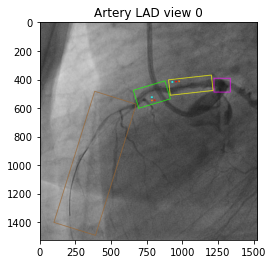

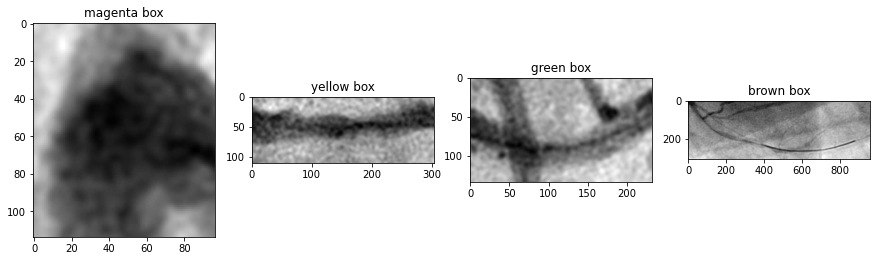

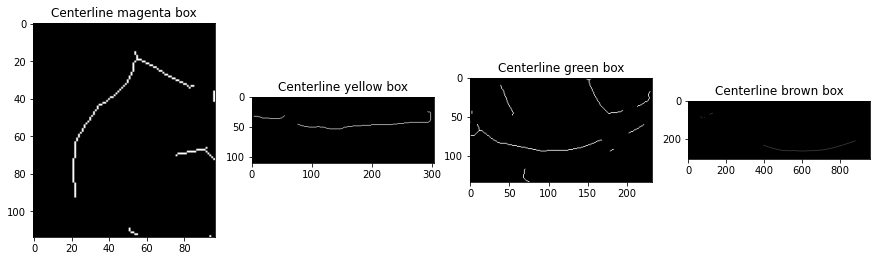

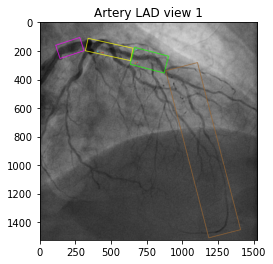

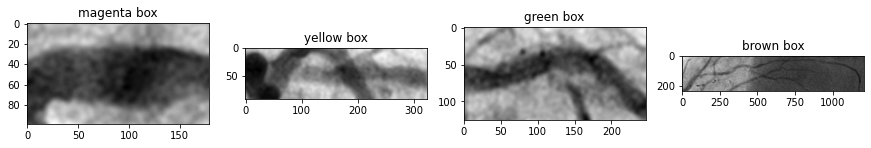

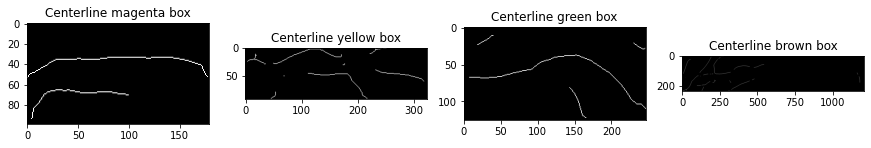

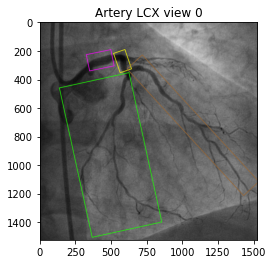

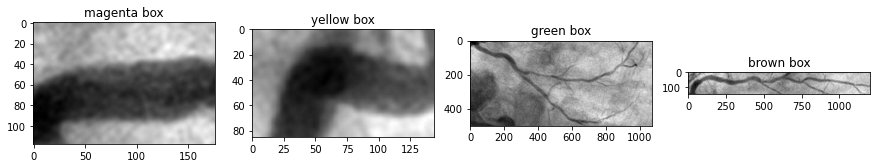

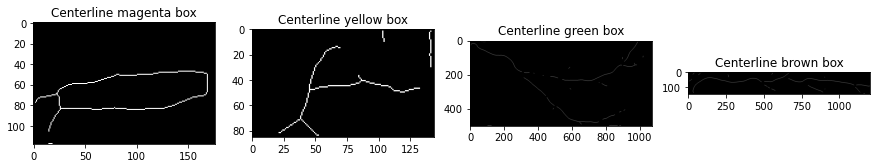

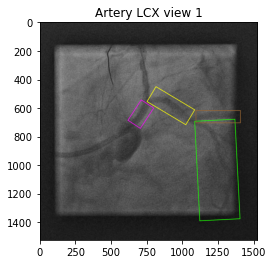

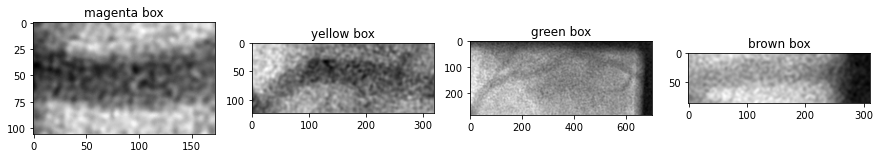

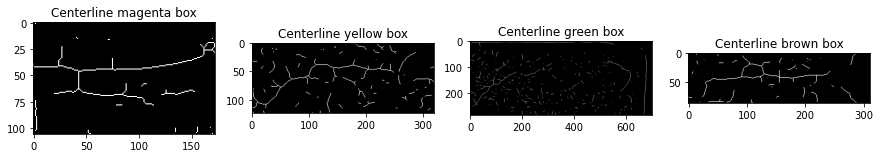

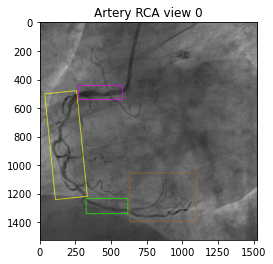

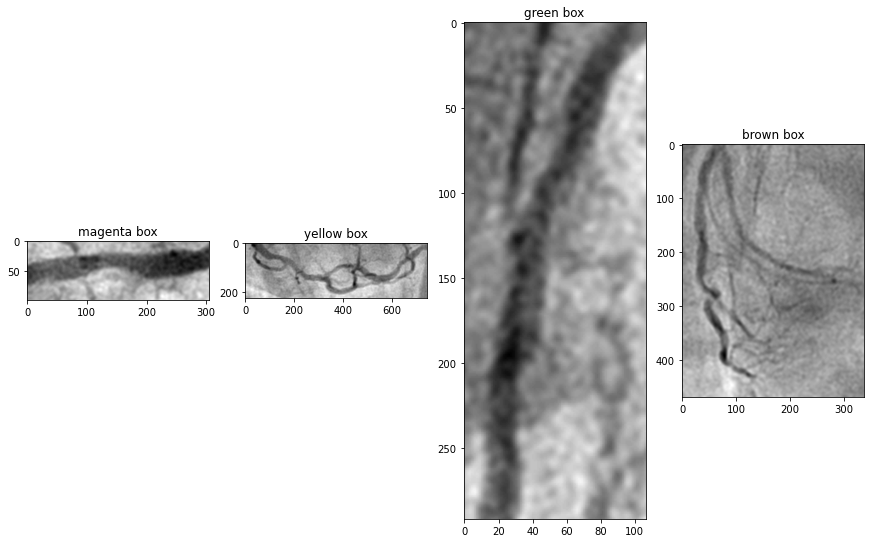

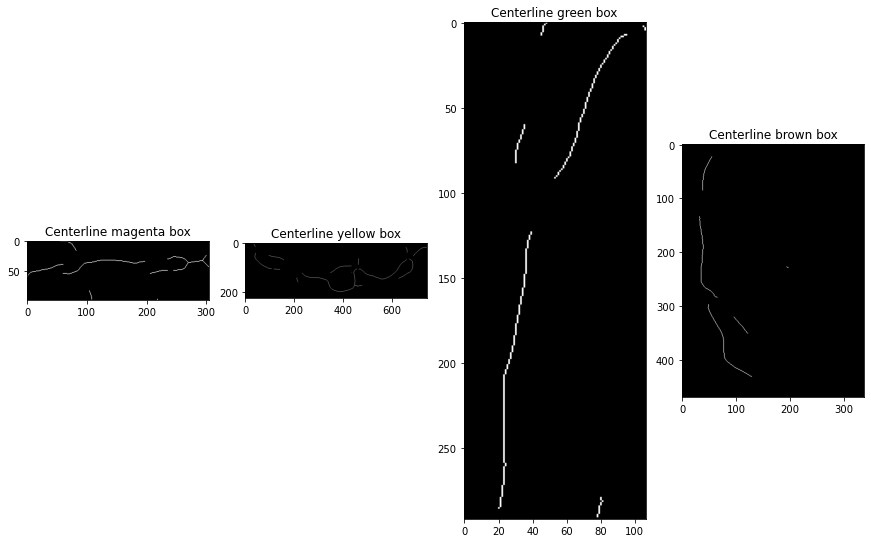

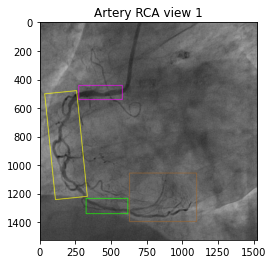

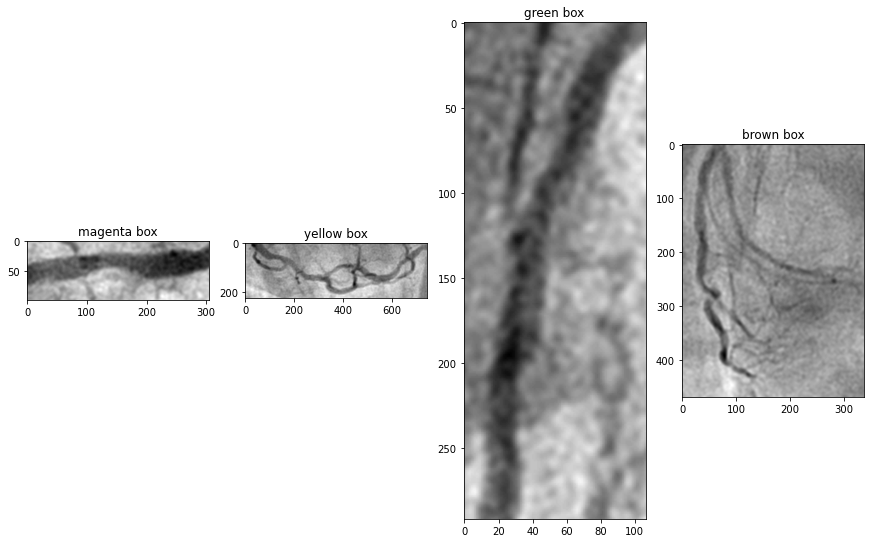

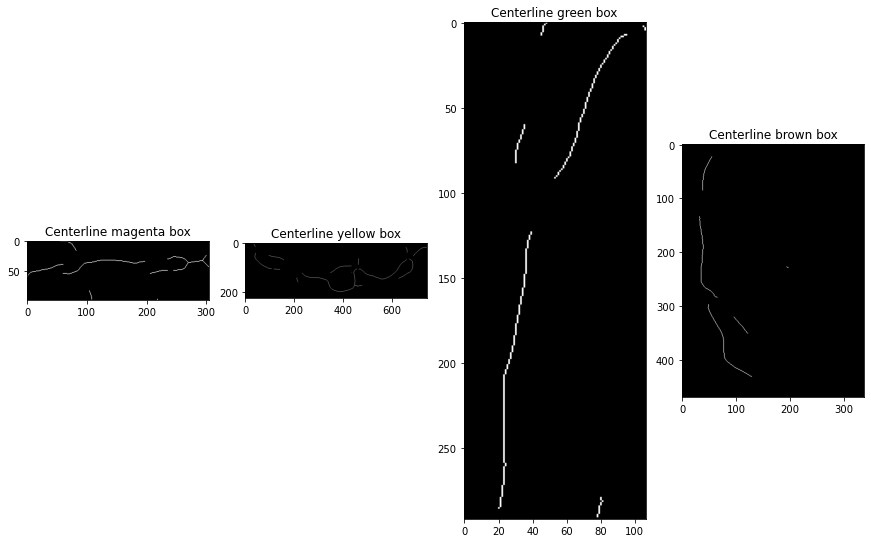

In [33]:
patient_names = region_level_df_boxes_complete.index.get_level_values('patient_name')
patient_name = patient_names.to_series().sample(1)

patient_rows = region_level_df_boxes_complete.loc["patient21"]  # region_level_df_boxes_complete.loc[patient_name]
#patient_rows = patient_rows.reset_index(level="patient_name", drop=True)
#print(patient_name.values[0])
result = get_all_patient_boxes(patient_rows, debug=True)

# Create a tensor dataset class

In [25]:
class AttentionDataset():
    def __init__(self, df, debug=False):
        self.df = df
        self.patient_names = df.index.get_level_values('patient_name').to_series().unique()
        self.debug = debug

    def __len__(self):
        return len(self.patient_names)

    def __getitem__(self,idx):
        """
        Each patient has:
            patient_name: its name
            all_imgs_patient: its boxes images (3 arteries 4 boxes 2 views 2 images (box+centerline))
            global_mi: lad mi, lcx mi, rca mi, mi 
            mi_all_boxes: for each arterx (lad, lcx, rca), the MI state of the boxes
        """
        
        patient_name = self.patient_names[idx]
        patient_rows =  self.df.loc[patient_name]
        available_arteries = patient_rows.index.get_level_values("segment_box").unique().values
        
        available_arteries_tensor = torch.tensor(["LAD" in available_arteries,
                                                 "LCX" in available_arteries,
                                                 "RCA" in available_arteries])
        
        mi = torch.tensor(patient_rows["target_box"].max(), dtype=torch.float)
        
        try:
            mi_lad = torch.tensor(patient_rows.loc["LAD"]["target_box"].max(), dtype=torch.float)
        except:
            mi_lad = torch.tensor(-1)
        try:
            mi_lcx = torch.tensor(patient_rows.loc["LCX"]["target_box"].max(), dtype=torch.float)
        except:
            mi_lcx = torch.tensor(-1)
        try:
            mi_rca = torch.tensor(patient_rows.loc["RCA"]["target_box"].max(), dtype=torch.float)
        except:
            mi_rca = torch.tensor(-1)
        global_mi = torch.stack((mi_lad, mi_lcx, mi_rca, mi), 0)
        
        try:
            mi_lad_all = torch.tensor(patient_rows.loc["LAD"]["target_box"].values, dtype=torch.float)
        except:
            mi_lad_all = -1*torch.ones(4)
        try:
            mi_lcx_all = torch.tensor(patient_rows.loc["LCX"]["target_box"].values, dtype=torch.float)
        except:
            mi_lcx_all = -1*torch.ones(4)
        try:
            mi_rca_all = torch.tensor(patient_rows.loc["RCA"]["target_box"].values, dtype=torch.float)
        except:
            mi_rca_all = -1*torch.ones(4)
        mi_all_boxes = torch.stack((mi_lad_all, mi_lcx_all, mi_rca_all), 0)

        all_imgs_patient = get_all_patient_boxes(patient_rows, debug=self.debug)
        
        return patient_name, available_arteries_tensor, all_imgs_patient, global_mi, mi_all_boxes

### Example

In [26]:
dataset = AttentionDataset(region_level_df_boxes_complete, True)
print("Dataset has {} patients".format(dataset.__len__()))

Dataset has 467 patients


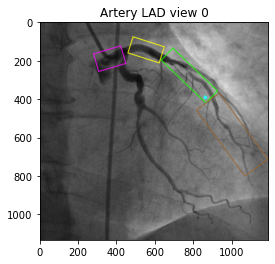

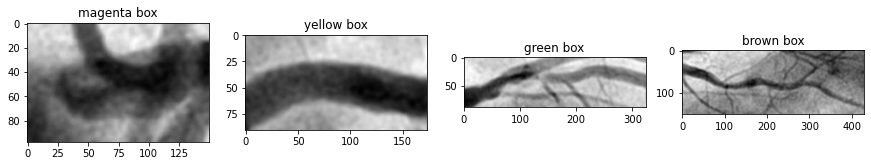

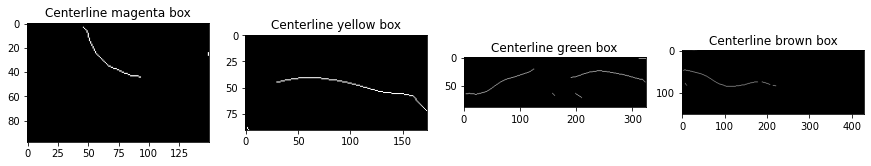

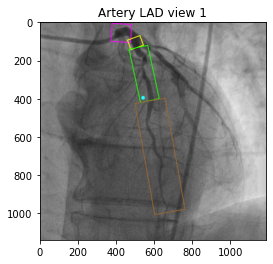

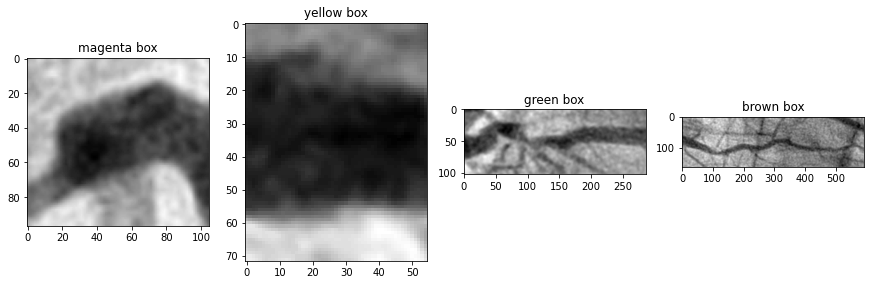

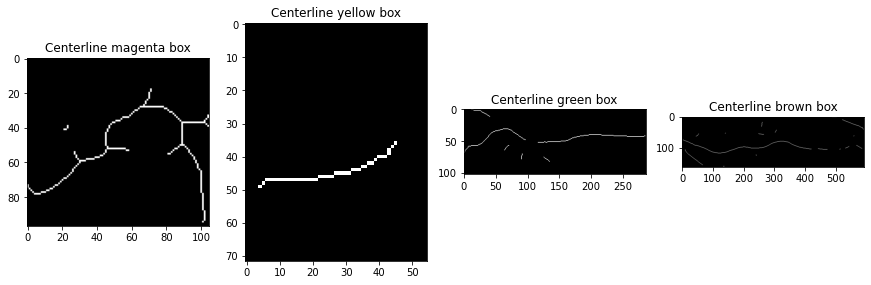

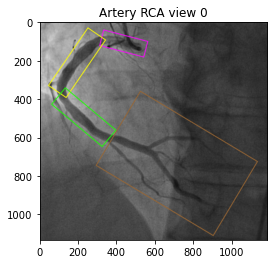

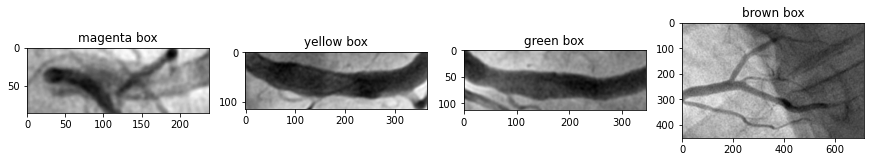

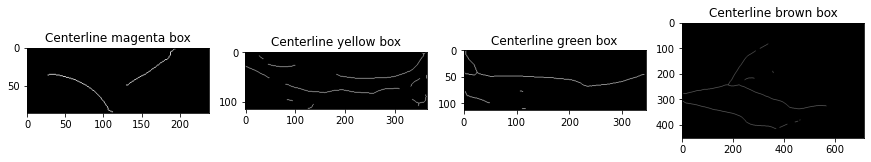

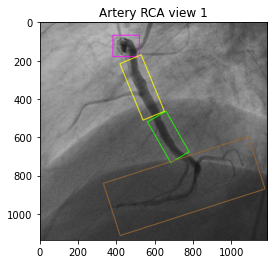

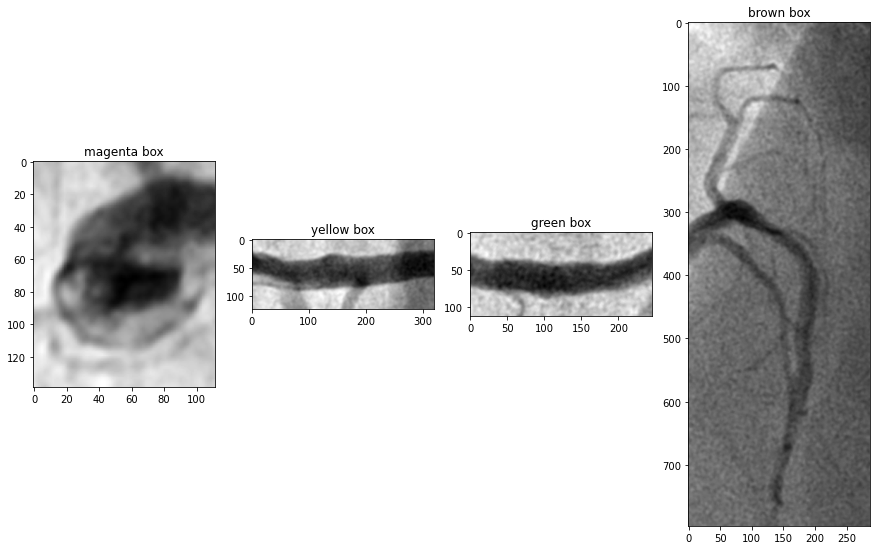

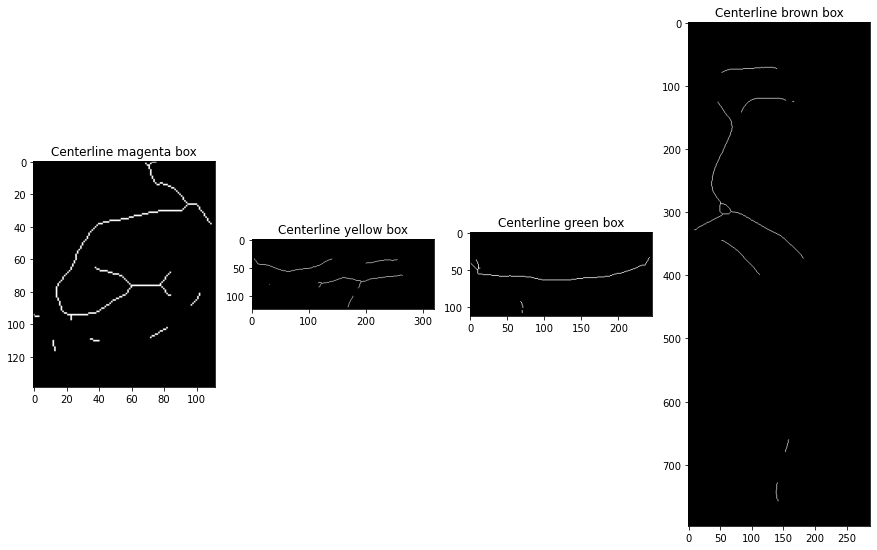

In [27]:
patient_name, available_arteries, patient_data, global_mi, mi_all_boxes = dataset.__getitem__(0)

In [28]:
patient_name

'patient1'

In [29]:
available_arteries

tensor([ True, False,  True])

In [30]:
global_mi

tensor([ 0., -1.,  0.,  0.])

In [31]:
mi_all_boxes

tensor([[ 0.,  0.,  0.,  0.],
        [-1., -1., -1., -1.],
        [ 0.,  0.,  0.,  0.]])

# Save the dataset as torch tensors

Not possible to use FFCV due to different size of boxes...

In [33]:
# avoid running it by error
assert False

basepath = "transformer_patient_torch_tensors"
try:
    os.mkdir(basepath)
except FileExistsError:
    print("Folder exists.")
dataset = AttentionDataset(region_level_df_boxes_complete, False)

for i in range(dataset.__len__()):
    if i%100 == 0:
        print(i, dataset.__len__())
    
    try:
        patient_name, available_arteries, patient_data, global_mi, mi_all_boxes = dataset.__getitem__(i)
    except FileNotFoundError as e:
        print(e)
        print("{} has not original images".format(patient_name))
        continue
    os.mkdir(basepath+"/"+patient_name)
    
    torch.save(available_arteries, basepath+"/"+patient_name+"/available_arteries.pt")
    torch.save(global_mi, basepath+"/"+patient_name+"/global_mi.pt")
    torch.save(mi_all_boxes, basepath+"/"+patient_name+"/mi_all_boxes.pt")
    
    for i_artery, artery in enumerate(["lad", "lcx", "rca"]):
        if available_arteries[i_artery]:
            for i_view, view in enumerate(["view1", "view2"]):
                for i_sect, section in enumerate(["magenta", "yellow", "green", "brown"]):
                    torch.save(torch.tensor(patient_data[i_artery][i_sect][i_view][0], dtype=torch.float), 
                               basepath+"/"+patient_name+"/"+artery+"_"+view+"_"+section+"_box.pt")
                    torch.save(torch.tensor(patient_data[i_artery][i_sect][i_view][1], dtype=torch.float), 
                               basepath+"/"+patient_name+"/"+artery+"_"+view+"_"+section+"_centerline.pt")

0 467
[Errno 2] No such file or directory: '../../Labelling_EPFL_CHUV/Farhang NCL/091-321-350_314056602_07.06.2014/LAD_2 copie.tif'
patient108 has not original images
100 467
200 467
300 467
400 467


### Check the result

tensor([ True, False,  True])
tensor([ 0., -1.,  0.,  0.])
tensor([[ 0.,  0.,  0.,  0.],
        [-1., -1., -1., -1.],
        [ 0.,  0.,  0.,  0.]])


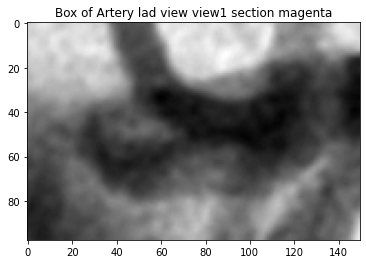

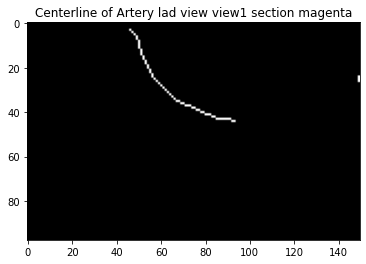

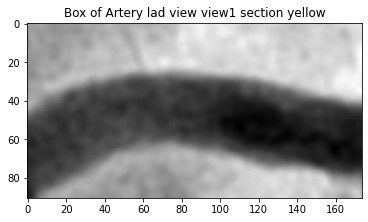

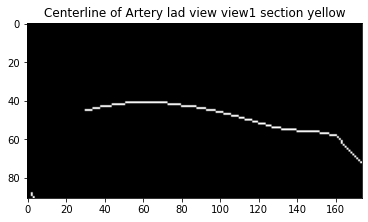

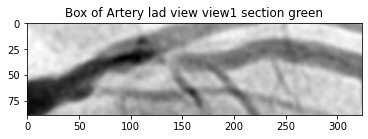

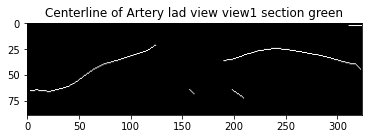

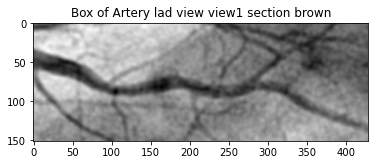

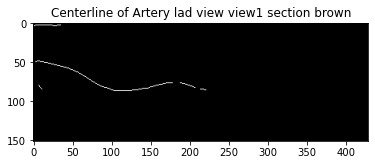

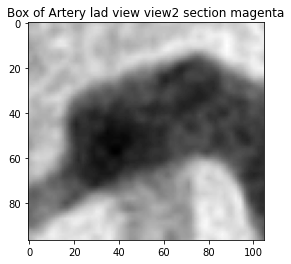

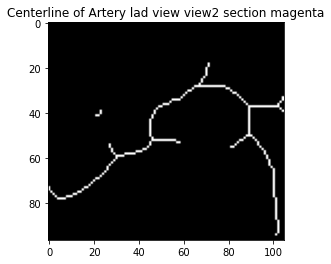

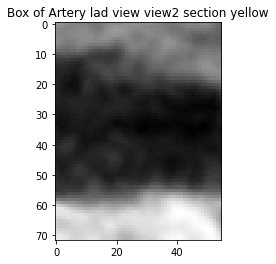

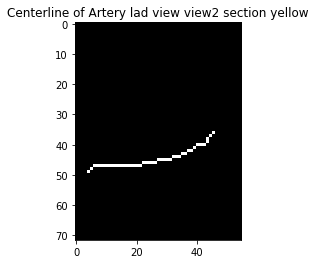

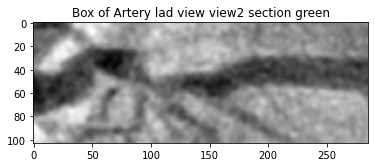

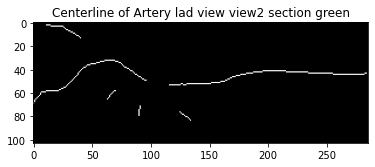

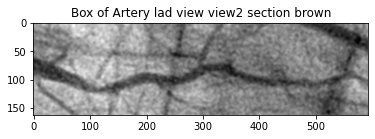

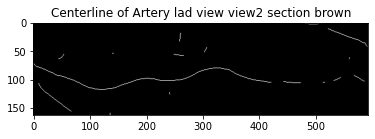

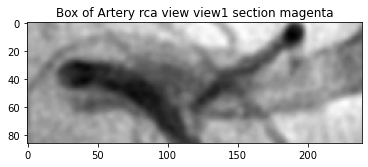

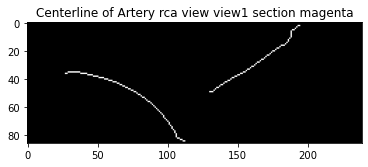

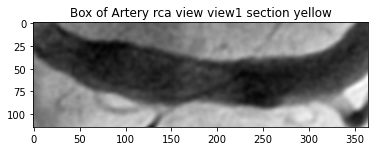

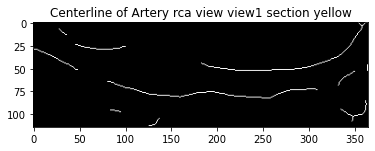

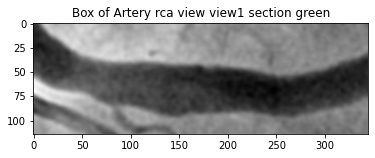

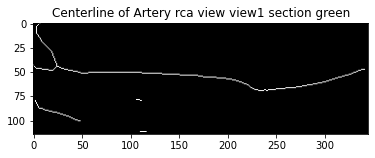

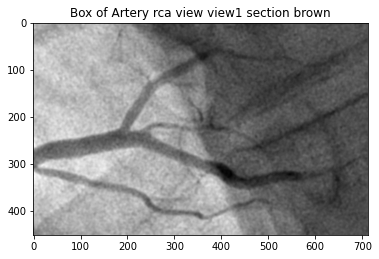

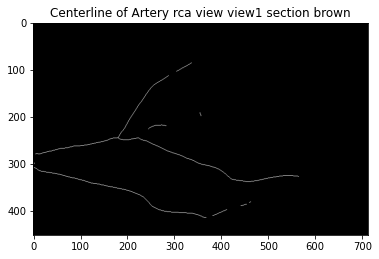

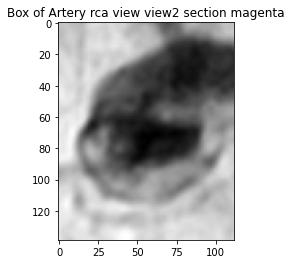

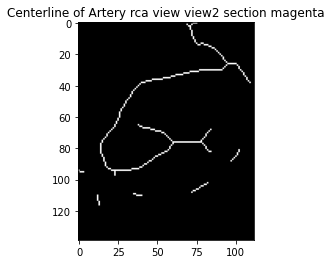

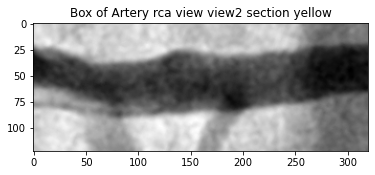

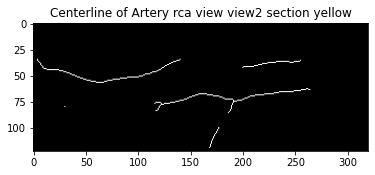

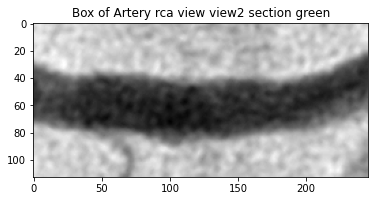

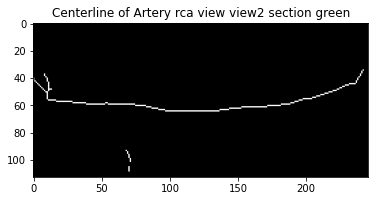

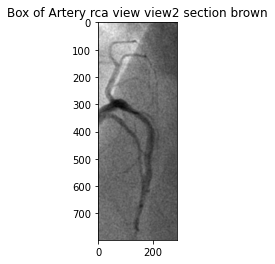

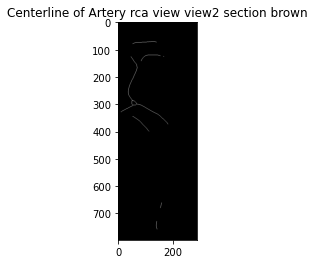

In [34]:
patient_name = "patient1"
  
available_arteries = torch.load(basepath+"/"+patient_name+"/available_arteries.pt")
print(available_arteries)
mi = torch.load(basepath+"/"+patient_name+"/global_mi.pt")
print(mi)
mi_all_boxes = torch.load(basepath+"/"+patient_name+"/mi_all_boxes.pt")
print(mi_all_boxes)

all_patches = [[[] for k in range(0,2)] for i in range(0,3)]

for i_artery, artery in enumerate(["lad", "lcx", "rca"]):
    if available_arteries[i_artery]:
        for i_view, view in enumerate(["view1", "view2"]):
            for i_sect, section in enumerate(["magenta", "yellow", "green", "brown"]):

                box = torch.load(basepath+"/"+patient_name+"/"+artery+"_"+view+"_"+section+"_box.pt")
                centerline = torch.load(basepath+"/"+patient_name+"/"+artery+"_"+view+"_"+section+"_centerline.pt")

                plt.imshow(box, cmap="gray")
                plt.title("Box of Artery {} view {} section {}".format(artery, view, section))
                plt.show()

                plt.imshow(centerline, cmap="gray")
                plt.title("Centerline of Artery {} view {} section {}".format(artery, view, section))
                plt.show()

### To work with patient data, we create a way to convert the name of the patient to its SJID

In [29]:
# Load original df
original_df = pd.read_pickle("transformer_df.pkl")

# make sure all same type of path
tmp_df = original_df.reset_index().copy()
tmp_df = tmp_df[["patient_name", "path_view1"]]
tmp_df["path_view1"] = tmp_df["path_view1"].str.split("/").str[-2].str[0:11]
tmp_df = tmp_df.rename(columns={"path_view1":"patient_sjid"})
tmp_df = tmp_df[["patient_name", "patient_sjid"]].groupby("patient_name").agg(pd.Series.mode) #remove repetition

# Save the df
tmp_df.to_csv("df_patient_names_to_sjid.csv")

# Example
tmp_df.head(5)

,patient_sjid
patient_name,
patient1,007-756-51X
patient10,193-141-302
patient100,080-324-078
patient101,081-633-184
patient102,081-983-918


In [ ]:
# Create sjid <-> name df
original_df["sjid"] = original_df["path_view1"].str.split('/').str[-2].str[0:11]
name_to_sjid_df = original_df[["patient_name", "sjid"]].groupby("patient_name").agg(pd.Series.mode).reset_index()

# Example
name_to_sjid_df.head(5)

---